In [1]:
#Import Packages
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import healpy as hp
import pandas as pd
import camb 
from camb import model, initialpower
%matplotlib inline


In [2]:
def basicgenmap(_strt, _stop, _NSIDE):  # (start, stop, NSIDE)
    '''
    Generate a basic map which is just an array with element values which are increasing from a 'start' to a 'stop'.
    '''
    _NPIX = 12*_NSIDE**2 #The number of pixels in a map, NPIX = 12*(NSIDE)^2
    return   np.linspace(_strt,_stop,_NPIX)        #generates an array in the 'ring' scheme


In [3]:
#Use CAMB to generate a power spectrum
def call_CAMB_map(_parameters, _lmax): #lmax above 2551 makes no difference?
    '''
    parameters = [H0, ombh2, omch2, mnu, omk, tau]  = [Hubble Const, Baryon density, DM density, 
    Sum 3 neutrino masses/eV, Curvature parameter (Omega kappa), Reionisation optical depth]
    '''
    if _lmax <= 2551: #can only find power spectrum for lmax <= 2551 since that is the maximum value of the data.
        pars = camb.CAMBparams()
        pars.set_cosmology(H0 = _parameters[0], ombh2 = _parameters[1], omch2 = _parameters[2], mnu = _parameters[3],
                   omk = _parameters[4], tau = _parameters[5])  #Inputs the given cosmological parameters.
        pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
        
        pars.set_for_lmax(_lmax, lens_potential_accuracy=0) #input the given lmax value
        
        results = camb.get_results(pars)
        powers =results.get_cmb_power_spectra(pars, CMB_unit='muK') #returns the power spectrum in units muK.
        
        totCL=powers['total'] #returns the total (averaged) power spectrum - including lensed, unlensed power spectra 
        _DL = totCL[:,0] 
        
        #unlensedCL=powers['unlensed_scalar'] #returns the unlensed scalar power spectrum
        #_DL = unlensedCL[:,0] # 
    
        _l = np.arange(len(_DL)) #not sure this CL is actually CL but is actually DL
        _CL = []
        for i in range(_lmax): #also limits the length of power spectrum to the requested length
            if i == 0:
                _CL.append(_DL[i]) #since unsure what CL value is for this DL
        
            else:
                _CL.append(_DL[i]/(_l[i]*(_l[i] + 1)))
        
        _CL = np.array(_CL)    
    
        return _CL 
    
    else: #prints error if lmax is too large.
        print('lmax value is larger than the available data.')

In [4]:
#Plots a given power spectrum 
def plotpwrspctrm(_cls):
    _l = np.arange(len(_cls))
    plt.figure()
    plt.plot(_l, _l * (_l + 1) * _cls)
    plt.xlabel("$\l$")
    plt.ylabel("$\l(\l+1)C_{\l}$")
    plt.grid()
    plt.title("Power Spectrum")
    plt.show()

#PLots a map in the mollview projection 
def mollviewmap(_map):
    hp.mollview(_map, title="Map displayed in the Aithoff projection", cmap = None)
    hp.graticule()


In [5]:
#Adds random noise to each pixel on a map given a variance 
def noisemap(_map,_var):
    _noisevec = np.random.normal(0,_var,len(_map))
    _newmap = [x + y for x, y in zip(_map, _noisevec)]
    _newmap, _noisevec = np.array(_newmap), np.array(_noisevec)
    return [_newmap, _noisevec] #rerturns an array consisiting of [map with added noise, array of the added noise]


In [6]:
#cls --> something
def cltoalm(_cls, _NSIDE): #does this manually - doesn't work
    _alms = []
    _lmax = (3*_NSIDE)
    _count = 0
    for l in range(_lmax): 
        if _cls[l] > 0:
            _alms.append(np.complex(np.random.normal(0,_cls[l]),0))        #set m=0, which is real
        else:
            _alms.append(np.complex(0,0))
        
        for m in range(l): #set positive m's
            if _cls[l] > 0 and _cls[m] > 0:
                _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),np.random.normal(0,0.5*_cls[m])))
            if _cls[l] > 0 and _cls[m] <= 0:
                _alms.append(np.complex(np.random.normal(0,0.5*_cls[l]),0))
            if _cls[l] <= 0 and _cls[m] > 0:
                _alms.append(np.complex(0,np.random.normal(0,0.5*_cls[m])))
            else:
                _alms.append(np.complex(0,0))
    
    return _alms   

def hpcltoalm(_cls, _NSIDE): #Healpy generate alms given cls
    return hp.synalm(_cls, lmax = (3*_NSIDE) - 1, new = True)

def cltomap(_cls, _NSIDE):
    _alm = cltoalm(_cls, _NSIDE)
    return almtomap(_alm, _NSIDE)

def hpcltomap(_cls, _NSIDE):   #Healpy generate a map given a power spectrum
    return hp.synfast(_cls, _NSIDE, new=True)   #pixwin=False, fwhm=np.radians(7.0),


In [7]:
#map --> something
def maptocl(_map):
    return

def hpmaptocl(_map): #Generate a power spectrum given cls
    return hp.anafast(_map, lmax=int(((3*(len(_map)/12)**0.5)-1)))    #lmax = 3NSIDE -1 by default

def maptoalm(_map):
    _omegp = (4*np.pi)/len(_map)
    _lmax = int(np.sqrt(len(_map)*(3/4)))
    _NSIDE = int(_lmax/3)
    _alm = []
    for l in range(_lmax):
        for m in range(l+1):
            _TpYlm = []
            for i in range(len(_map)):
                _TpYlm.append(_map[i]*np.conjugate(sphharm(m, l, i, _NSIDE)))
                    
            _alm.append(_omegp*sum(_TpYlm))
    
    return _alm


def hpmaptoalm(_map, _lmax): #Healpy generate alms from map. 
    return hp.map2alm(_map, _lmax)


In [8]:
#alm --> something
def almtocl(_alm,lmax): #not the same value as healpy
    _l = np.arange(lmax)
    _scaling = 1 / ((2*_l + 1))
    count = 0
    _new = []
    _cl = []
    for l in range(lmax):
        _new.append([])
        for m in range(l):
            if m == 0:
                _new[l].append(np.absolute(_alm[count])**2)
                count = count + 1
                
            if m > 0:
                _new[l].append(2*np.absolute(_alm[count])**2)
                count = count + 1
              
    for i in range(len(_new)):
        _cl.append(_scaling[i] * sum(_new[i]))
    
    return _cl

def hpalmtocl(_alms, _lmax): #Healpy estimates the power spectrum from the cls.
    return hp.alm2cl(_alms, lmax = _lmax)

def almtomap(_alm, _NSIDE):
    _map = []
    _lmax = (3*_NSIDE)
    for i in range(12*(_NSIDE)**2):
        _sum = []
        _count = 0
        for l in range(_lmax+1):
            for m in range(l):
                _sum.append(_alm[_count]*sphharm(m,l,i, _NSIDE))
                _count = _count + 1
        _map.append(abs(sum(_sum)))
    return _map


def hpalmtomap(_alms, _NSIDE):
    return hp.alm2map(_alms, _NSIDE)

In [9]:
#healpy smoothing for the map and the alms
def hpmapsmooth(_map, _lmax): #smooths a given map with a gaussian beam smoother.
    return hp.smoothing(_map, lmax = _lmax)

def hpalmsmooth(_alms): #smooths a given set of alms with a gaussian beam smoother.
    return hp.smoothalm(_alms, fwhm = 0.0)
    

In [10]:
#splits/rejoins the alms into real/imaginary parts so that they can be optimised with scipy.optimize.minimize()
def singulartosplitalm(_alm):
    _realalm, _imagalm = _alm.real, _alm.imag
    return [_realalm, _imagalm]
    

def splittosingularalm(_realalm, _imagalm):
    _alm = []
    for i in range(len(_realalm)):
        _alm.append(complex(_realalm[i], _imagalm[i]))
    return _alm

In [11]:
#Retrieves the spherical harmonics for a given, l, m and pixel number
def sphharm(m, l, _pixno, _NSIDE):
    _theta, _phi = hp.pix2ang(nside=_NSIDE, ipix=_pixno)
    return sp.special.sph_harm(m, l, _theta, _phi)
    

In [12]:
#negative log of the posterior, psi, ignoring the prior term.
def psi(_params, _map, _lmax, _Ninv): #unnormalised log probability
    _cl, _realalm, _imagalm = [], [], []
    
    for i in range(a1):
        _cl.append(_params[i])
    for i in range(a2):
        _realalm.append(_params[i + a1])
    for i in range(a2):
        _imagalm.append(_params[i + a1 + a2])
    
    _d = _map
    _a = splittosingularalm(_realalm, _imagalm)
    _Ya = almtomap(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    _elem, _psi1 ,_psi2, _psi3 = [], [], [], []
    for i in range(len(_d)):
        _elem.append(_d[i] - _BYa[i])
        _psi1.append(0.5*(_elem[i]**2)*_Ninv[i])
    
    for l in range(_lmax):
        if _cl[l] > 0:
            _psi2.append((2*l+1)*np.log(_cl[l]))
    
    for i in range(len(_a)):
        _psi3.append(abs(_a[i])**2)
        
    _psi = sum(_psi1) + sum(_psi2) + sum(_psi3)
    print('psi =',_psi)
    return _psi

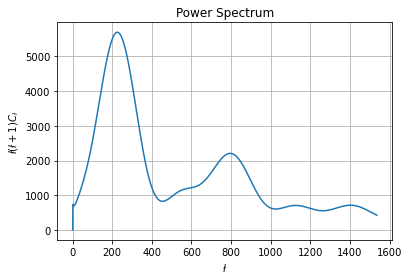

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

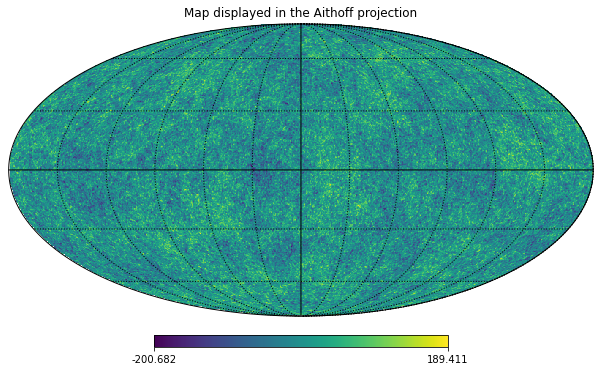

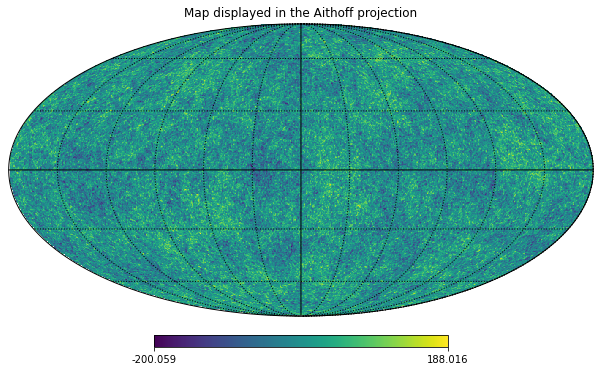

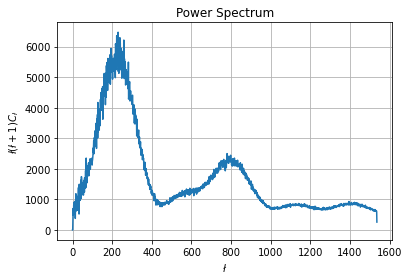

In [13]:
#Trial with parameters 1
parameters1 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax1 = 1536  #lmax value wanted from data
NSIDE1 = int(lmax1/3)  #len(cls1)/3   #3*nside = len(cls)
n1 = np.linspace(5,5,(12*(NSIDE1)**2))
Ninv1 = []
for i in range(len(n1)):
    Ninv1.append(1/(n1[i]**2)) #finds the inverse noise matrix

cls1 = call_CAMB_map(parameters1, lmax1) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls1) #plot of the power spectrum.
map1 = hpcltomap(cls1, NSIDE1)  #generates a map from the power spectrum
map1 = hpmapsmooth(map1, lmax1) #applies a gaussian beam smoother to the map
mollviewmap(map1) #plots the map
noisemap1 = noisemap(list(map1),n1[0])[0] #adds noise to the map
mollviewmap(noisemap1) #plots the map with noise
alms1 = hpmaptoalm(noisemap1,lmax1) #computes the alms from the map with noise added.
CLestimate1 = hpalmtocl(alms1, lmax1) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate1) #plots the estimated power spectrum.


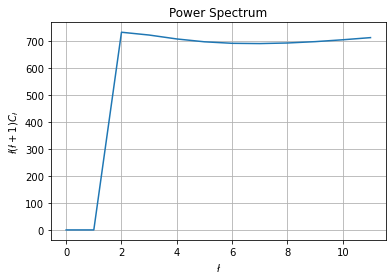

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

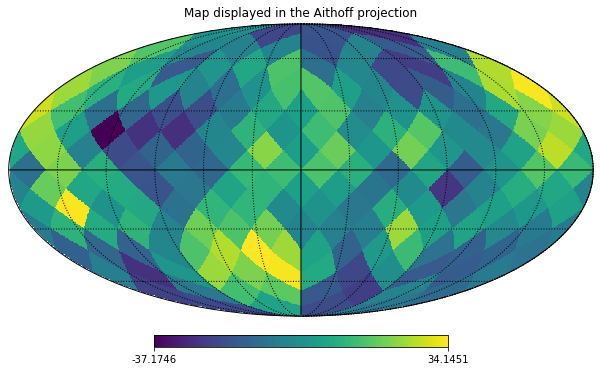

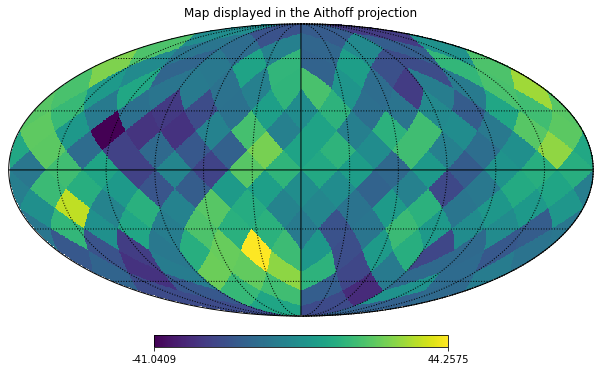

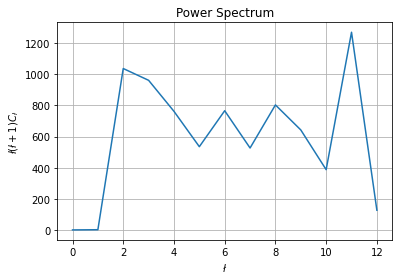

In [14]:
#Trial with parameters 2
parameters2 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax2 = 12   #lmax value wanted from data
NSIDE2 = int(lmax2/3)   #len(cls1)/3   #3*nside = len(cls)
n2 = np.linspace(5,5,(12*(NSIDE2)**2))
Ninv2 = []
for i in range(len(n2)):
    Ninv2.append(1/(n2[i]**2)) #finds the inverse noise matrix
    

cls2 = call_CAMB_map(parameters2, lmax2) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls2) #plot of the power spectrum.
map2 = hpcltomap(cls2, NSIDE2)  #generates a map from the power spectrum
map2 = hpmapsmooth(map2, lmax2) #applies a gaussian beam smoother to the map
mollviewmap(map2) #plots the map
noisemap2 = noisemap(map2,n2[0])[0] #adds noise to the map
mollviewmap(noisemap2) #plots the map with noise
alms2 = hpmaptoalm(noisemap2,lmax2) #computes the alms from the map with noise added.
CLestimate2 = hpalmtocl(alms2, lmax2) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate2) #plots the estimated power spectrum.


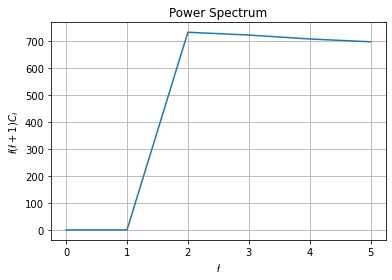

/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:920: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  newcm.set_over(newcm(1.0))
/home/oscar/anaconda3/envs/hp/lib/python3.7/site-packages/healpy/projaxes.py:921: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colorm

TypeError: 'numpy.float64' object is not iterable

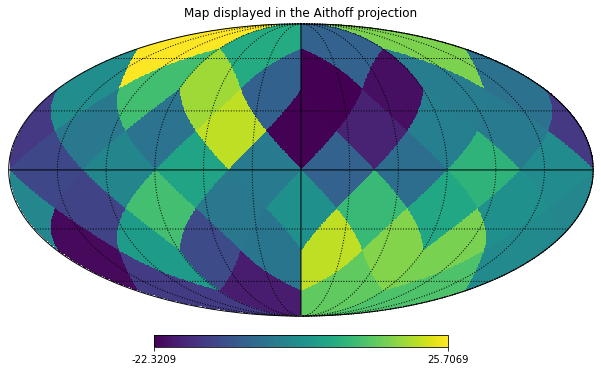

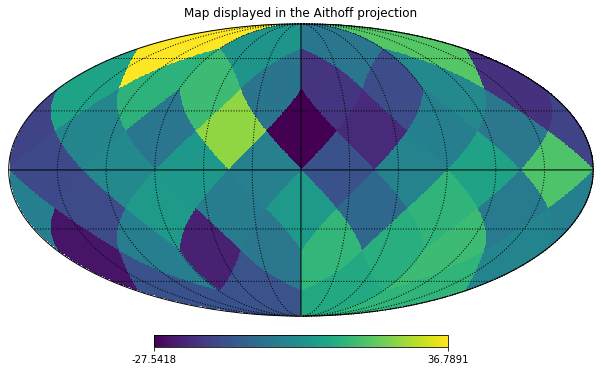

In [15]:
#Trial with parameters 3
parameters3 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax3 = 6  #lmax value wanted from data
NSIDE3 = int(lmax3/3)  #len(cls1)/3   #3*nside = len(cls)
n3 = np.linspace(5,5,(12*(NSIDE3)**2))
Ninv3 = []
for i in range(len(n3)):
    Ninv3.append(1/(n3[i]**2)) #finds the inverse noise matrix

cls3 = call_CAMB_map(parameters3, lmax3) #power spectrum for the given parameters and lmax.
plotpwrspctrm(cls3) #plot of the power spectrum.
map3 = hpcltomap(cls3, NSIDE3)  #generates a map from the power spectrum
map3 = hpmapsmooth(map3, lmax3) #applies a gaussian beam smoother to the map
mollviewmap(map3) #plots the map
noisemap3 = noisemap(map3,n3[0])[0] #adds noise to the map
mollviewmap(noisemap3) #plots the map with noise
alms3 = hpmaptoalm(noisemap3,lmax3) #computes the alms from the map with noise added.
CLestimate3 = hpalmtocl(alms3, lmax3) #estimates the power spectrum from the given alms.
plotpwrspctrm(CLestimate3) #plots the estimated power spectrum.


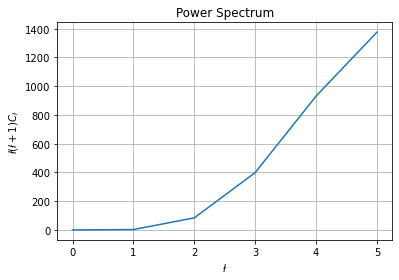

In [17]:
#Trial with parameters 4
parameters4 = [67.74, 0.0486, 0.2589, 0.06, 0.0, 0.066] #cosmological parameters.
lmax4 = 6  #lmax value wanted from data
NSIDE4 = int(lmax4/3)  #len(cls1)/3   #3*nside = len(cls)
n4 = np.linspace(5,5,(12*(NSIDE4)**2))
Ninv4 = []
for i in range(len(n4)):
    Ninv4.append(1/(n4[i]**2)) #finds the inverse noise matrix
    
cls4 = call_CAMB_map(parameters4, lmax4) #power spectrum for the given parameters and lmax.
map4 = hpcltomap(cls4, NSIDE4)  #generates a map from the power spectrum
map4 = hpmapsmooth(map4, lmax4) #applies a gaussian beam smoother to the map
noisemap4 = noisemap(map4,n4[0])[0] #adds noise to the map

noisealm4 = np.array(maptoalm(noisemap4)) #recover cls from map
noisecl4 = almtocl(noisealm4, lmax4)
plotpwrspctrm(noisecl4) #plots the estimated power spectrum.


In [18]:
#inital values for the optimisation of psi (with the values from parameters4)
noisemap = noisemap4
clinit = noisecl4
realalminit = noisealm4.real
imagalminit = noisealm4.imag
x0 = []
a1 = len(clinit)
a2 = len(realalminit)
a3 = len(imagalminit)
for i in range(len(clinit)):
    x0.append(clinit[i])
for i in range(len(realalminit)):
    x0.append(realalminit[i])
for i in range(len(imagalminit)):
    x0.append(imagalminit[i])
    
print('psi_init = ',psi(x0,noisemap,lmax4,Ninv4))

psi = 1378.099363437199
psi_init =  1378.099363437199


In [19]:
#optimising the psi funciton to get the parameters for the smallest value
sp.optimize.fmin(psi, x0, args = (noisemap, lmax4, Ninv4), xtol=0.1)

psi = 1378.099363437199
psi = 1369.805313797097
psi = 1378.2457339297073
psi = 1378.3433142580461
psi = 1378.4408945863852
psi = 1378.5384749147238
psi = 1378.6360552430629
psi = 1378.796643736333
psi = 1383.653190152883
psi = 1378.38199001852
psi = 1380.0361908068173
psi = 1378.1510298590717
psi = 1390.1072179111716
psi = 1378.1713998871824
psi = 1378.9400395262746
psi = 1381.5312637590064
psi = 1378.503221780924
psi = 1378.3932492248455
psi = 1378.190144264683
psi = 1383.8986843889052
psi = 1379.7989739551358
psi = 1393.6957727502652
psi = 1378.10038978284
psi = 1378.1044940311067
psi = 1383.037610355498
psi = 1382.6613982859742
psi = 1378.101586517123
psi = 1378.1358166155983
psi = 1378.0992151260189
psi = 1378.0994467757066
psi = 1379.093345198423
psi = 1378.099255218507
psi = 1378.4282667088164
psi = 1378.5960294872455
psi = 1378.0993952592303
psi = 1378.1921014638006
psi = 1378.1917250367105
psi = 1398.6199584826932
psi = 1378.099387757442
psi = 1378.1099947042471
psi = 1381.0137

psi = 1218.9399387624344
psi = 1221.7585562383647
psi = 1218.515689486733
psi = 1216.9798714096494
psi = 1216.6511037595096
psi = 1215.7149377841629
psi = 1214.9570599937429
psi = 1198.5261540825122
psi = 1213.4666856681251
psi = 1212.7425155752605
psi = 1212.1209407825213
psi = 1211.6306570052288
psi = 1210.292783472742
psi = 1210.98505645742
psi = 1210.2842360802233
psi = 1209.920314018318
psi = 1208.7546479457096
psi = 1207.8639705113487
psi = 1206.9893841252956
psi = 1206.5258342946677
psi = 1206.5308324147652
psi = 1207.6278184643531
psi = 1205.3692301737174
psi = 1204.609663458666
psi = 1201.7891867378837
psi = 1202.3625751219033
psi = 1201.5580645961913
psi = 1201.1777320720635
psi = 1199.8784046351466
psi = 1199.4089497329787
psi = 1198.7209805223692
psi = 1197.6986733036474
psi = 1181.5182117796055
psi = 1196.1150045335894
psi = 1194.8646513653812
psi = 1193.8837799131093
psi = 1193.1297485101522
psi = 1191.8555658504097
psi = 1192.1777195376353
psi = 1191.2454617392104
psi = 

psi = 973.4300441200973
psi = 973.9211355816474
psi = 974.0787989788597
psi = 973.6625000956806
psi = 973.425631924883
psi = 971.9483074215507
psi = 969.021982565662
psi = 971.5834524863975
psi = 968.9984102426303
psi = 970.7519491757478
psi = 969.7367453511222
psi = 966.8973354269322
psi = 968.7394478308927
psi = 966.3860478923043
psi = 982.0385688770525
psi = 965.4924860431188
psi = 965.3694436870462
psi = 965.9844150156069
psi = 963.4825359658735
psi = 964.2045797090177
psi = 963.498668440739
psi = 963.1166636445888
psi = 963.1053769107423
psi = 961.613636551402
psi = 951.2725310492191
psi = 958.2268819855078
psi = 960.8651968869215
psi = 960.0829606219665
psi = 960.1861991255856
psi = 958.8755637898718
psi = 958.6130979225255
psi = 958.2993269768674
psi = 957.6556756836064
psi = 957.1334020643101
psi = 957.186837655407
psi = 956.0282178908876
psi = 954.454210505856
psi = 960.0177412362011
psi = 955.6221084334211
psi = 955.8837794907898
psi = 953.8827582974316
psi = 954.266163277158

psi = 797.1155440336727
psi = 796.4751558986733
psi = 796.3218223758946
psi = 795.2131063269553
psi = 796.1645892961911
psi = 793.6027281341219
psi = 794.3060386702447
psi = 793.3120899673336
psi = 807.6347345327194
psi = 790.8642564052113
psi = 789.5871639795294
psi = 789.372015523161
psi = 789.0058715522033
psi = 789.2914206971018
psi = 787.0131370734925
psi = 786.4558713333608
psi = 788.0664472160304
psi = 785.8635739439499
psi = 783.4384009394402
psi = 766.746209320449
psi = 781.7200946701201
psi = 790.8797572857745
psi = 780.0221396751012
psi = 780.375163716777
psi = 779.9201734468752
psi = 779.705396041453
psi = 778.8412604768798
psi = 780.1886620575818
psi = 776.8230369443396
psi = 775.9857189430861
psi = 773.8032817907274
psi = 773.8455176095524
psi = 786.1922791944636
psi = 773.2042928000051
psi = 772.6392148553093
psi = 772.3254595343095
psi = 784.5675090581483
psi = 771.2469640406619
psi = 769.4583117541881
psi = 770.0662487835262
psi = 769.1048051488776
psi = 768.3232570312

psi = 600.9047985881407
psi = 593.8409206304465
psi = 587.2720516890228
psi = 600.4681543200855
psi = 593.4236423955422
psi = 586.4770028096954
psi = 586.353850503986
psi = 588.6214058629201
psi = 588.8003774037486
psi = 586.0791803724907
psi = 592.1705895296145
psi = 582.5892321942963
psi = 576.687251638053
psi = 586.4012980198386
psi = 583.5696306854732
psi = 581.8623207626994
psi = 583.6522190336551
psi = 585.066017975018
psi = 585.636916221089
psi = 582.8545011136246
psi = 591.0906897744853
psi = 585.1911612065342
psi = 586.4877056638327
psi = 589.7839150285948
psi = 587.3208918215851
psi = 582.6812511422152
psi = 580.65637016104
psi = 589.90734040921
psi = 584.726026842937
psi = 588.4196913195265
psi = 586.0837677344718
psi = 578.8953756873422
psi = 582.4157267460301
psi = 582.5812161173977
psi = 583.3027002426018
psi = 581.1270086517623
psi = 581.8236378131816
psi = 583.4569418113232
psi = 577.9579882220925
psi = 583.1231097083364
psi = 581.0639424730392
psi = 581.4355095078984
p

psi = 499.38695203394536
psi = 498.9337978596127
psi = 498.2400636686475
psi = 497.5646972913442
psi = 502.8542644606594
psi = 497.4377153261069
psi = 498.3117118477698
psi = 500.70958550538523
psi = 497.466455673105
psi = 502.9036150827882
psi = 494.68692019636114
psi = 499.9827902702348
psi = 499.4225907246582
psi = 494.4714301533048
psi = 494.57298264251693
psi = 505.19736668531345
psi = 497.9229480414076
psi = 497.87290127076403
psi = 496.4345815664031
psi = 494.0295166184736
psi = 493.55491950314683
psi = 497.43199690809246
psi = 493.54924709568286
psi = 492.95076841892865
psi = 494.0487110937877
psi = 492.4950676940202
psi = 491.42876816180456
psi = 493.96215154633876
psi = 496.48631570167476
psi = 501.37482316225277
psi = 491.6377767249272
psi = 497.43863396117194
psi = 492.3733471090576
psi = 493.2964368929342
psi = 492.7165785266851
psi = 492.1045833871667
psi = 489.1505159808212
psi = 485.8331955163992
psi = 493.31659056290096
psi = 496.28718737745817
psi = 494.9467584411677


psi = 442.5179624620654
psi = 438.58552692361195
psi = 441.60095459204734
psi = 435.3376131165043
psi = 438.0281325149863
psi = 436.521467837454
psi = 437.7212256458775
psi = 439.91139706841875
psi = 436.9763126502962
psi = 437.7155072707305
psi = 437.5861234907364
psi = 434.793446711941
psi = 440.3640625765265
psi = 436.7974501602429
psi = 438.5545685238275
psi = 439.57824830167965
psi = 439.73023716709974
psi = 444.3485062076938
psi = 441.84550141830425
psi = 439.49277574523376
psi = 440.1098617518797
psi = 438.510793102881
psi = 443.53909634130895
psi = 442.7387851392701
psi = 438.1102982660206
psi = 437.9166693426862
psi = 437.64244347836745
psi = 443.1155764597819
psi = 440.02749847013865
psi = 434.8696734185869
psi = 435.3226559845544
psi = 433.7781082448626
psi = 436.02588225449415
psi = 436.5294908356244
psi = 440.5781558025541
psi = 441.2444576272658
psi = 434.49093791286185
psi = 440.9024122853979
psi = 438.5331650831397
psi = 435.1606823871958
psi = 438.60546259588875
psi = 

psi = 411.63847788598576
psi = 414.8559150323848
psi = 413.948756203036
psi = 410.23213243154896
psi = 413.5556699274536
psi = 406.9699871495734
psi = 404.9108468698644
psi = 408.99327522962153
psi = 414.5095095655348
psi = 410.3203826835363
psi = 407.7159684322948
psi = 414.5022376628565
psi = 414.562960581694
psi = 407.78891942156963
psi = 412.76781594915957
psi = 410.32402212067586
psi = 412.5376763189653
psi = 411.80369891916627
psi = 408.159927199542
psi = 406.94642993350476
psi = 408.83087076317275
psi = 412.2887495461291
psi = 411.85806539351194
psi = 407.6838667104732
psi = 405.5689327552131
psi = 415.19070782246814
psi = 410.2062721648313
psi = 408.8663274339685
psi = 414.28775349122424
psi = 413.6622218545659
psi = 408.7456969624257
psi = 414.4329918283903
psi = 409.93468008579526
psi = 412.6767404203745
psi = 406.5127068221532
psi = 412.41061241008526
psi = 409.678363999534
psi = 413.1497187355201
psi = 410.37532673631404
psi = 408.3208723064266
psi = 409.1271397579934
psi =

psi = 392.2033451982912
psi = 388.09724627884987
psi = 391.7256345685536
psi = 390.14121248256845
psi = 387.3907319763686
psi = 390.57523286116026
psi = 389.3100143282249
psi = 387.53761236984303
psi = 390.24263741516774
psi = 390.31530929502736
psi = 388.24461985616944
psi = 392.1310294112974
psi = 388.1966939570517
psi = 390.77626637914017
psi = 388.19569584865684
psi = 386.32178754339947
psi = 389.0007122213575
psi = 388.0538904028794
psi = 386.87488327246507
psi = 386.65679671106125
psi = 387.3494059244688
psi = 387.5851990525655
psi = 385.95126225007743
psi = 385.9623671834288
psi = 390.57426554890253
psi = 385.7009782948437
psi = 385.6174562405914
psi = 389.56182200438093
psi = 383.65375349153004
psi = 379.8594464298294
psi = 386.29184642581885
psi = 387.2263701954381
psi = 386.06346955348886
psi = 387.2824308383118
psi = 386.82651530787035
psi = 387.4633765303674
psi = 384.15862484501895
psi = 383.99612748134354
psi = 383.6976498782513
psi = 385.60012354521507
psi = 386.56496523

psi = 373.26838834779187
psi = 366.5896000359917
psi = 373.21713156831095
psi = 366.5155909838238
psi = 373.3220322598827
psi = 366.35836169794084
psi = 373.24190060330807
psi = 366.22606207891846
psi = 373.3001857990758
psi = 366.1053683926267
psi = 373.20506750567955
psi = 365.997269598079
psi = 362.244738012234
psi = 373.214453891405
psi = 365.8532022569286
psi = 373.51968011513463
psi = 365.69255227212454
psi = 362.37644851664754
psi = 362.9959894314262
psi = 363.55961821228425
psi = 373.40302191364316
psi = 365.36879772123825
psi = 375.2807000336885
psi = 365.36699418111436
psi = 373.4298152092663
psi = 365.2569947588628
psi = 373.43457404481853
psi = 365.2161988958935
psi = 373.4219938439304
psi = 365.1408384433913
psi = 373.50965540755766
psi = 365.06177263133156
psi = 373.42342583400256
psi = 365.0457274632332
psi = 373.4042680011572
psi = 364.9811118139108
psi = 373.45923405532267
psi = 364.8631023854928
psi = 362.877437156023
psi = 373.4272874661499
psi = 364.7313259567446
ps

psi = 353.4160287852674
psi = 375.1532635218417
psi = 352.70882018306196
psi = 374.70049689801704
psi = 352.7606334869585
psi = 374.1066411797233
psi = 352.7087787120081
psi = 374.13278333008935
psi = 352.62575011767575
psi = 374.0543636652198
psi = 352.36047606913303
psi = 333.09455827095616
psi = 352.1727500060569
psi = 373.97185627177805
psi = 352.1248699610108
psi = 345.4480575019827
psi = 373.96582458339276
psi = 351.99461483316384
psi = 353.32525977232456
psi = 348.78886303621846
psi = 353.1313932095497
psi = 373.9034547773567
psi = 351.8444021572127
psi = 349.8907663479214
psi = 373.77980411996487
psi = 351.75508085773004
psi = 373.7847494049353
psi = 351.7107048060794
psi = 352.9698775260222
psi = 373.66081884332357
psi = 351.63192020595756
psi = 326.5813904930447
psi = 373.59085079977547
psi = 352.4064679042749
psi = 348.15642920849143
psi = 373.7389134417258
psi = 351.35508300613384
psi = 373.7417765316251
psi = 351.3024628356212
psi = 373.95125478701055
psi = 351.27562736861

psi = 373.75470791498
psi = 338.52392564093685
psi = 373.7579680388932
psi = 338.4422345132841
psi = 336.21088310087345
psi = 373.7483199515853
psi = 338.3353312310348
psi = 373.81488489743145
psi = 338.2520508457542
psi = 373.7809546187857
psi = 338.25331979709057
psi = 373.7377009309773
psi = 338.20653730551203
psi = 326.6225471635155
psi = 327.688972494058
psi = 373.78328636893315
psi = 338.0445139762661
psi = 330.7733181029628
psi = 373.99546612093644
psi = 337.93921688759747
psi = 373.8636552326724
psi = 337.93934988216336
psi = 373.85447614566846
psi = 337.81284505123887
psi = 373.8837783480124
psi = 337.75255978398025
psi = 373.8635694191601
psi = 337.6701392410925
psi = 373.8672052954853
psi = 337.6084456360443
psi = 373.87508277890197
psi = 337.281835940361
psi = 373.8460318003726
psi = 337.23743705560605
psi = 373.8494241884484
psi = 337.17796721086205
psi = 335.8610716969945
psi = 373.89986717345175
psi = 337.0786494393282
psi = 373.9024492181875
psi = 337.0229068690958
psi 

psi = 325.15065582550847
psi = 314.15241545002624
psi = 374.1162143427511
psi = 324.9917848583886
psi = 315.8140089820594
psi = 374.11559202855426
psi = 324.84159995552295
psi = 315.2430207370421
psi = 374.00962303749554
psi = 324.5852204941035
psi = 374.0825089576625
psi = 324.54986717541203
psi = 374.02403963531356
psi = 324.4297064291652
psi = 374.0018312468911
psi = 324.34296257061203
psi = 374.0047424139877
psi = 324.28097160157347
psi = 374.02632750807777
psi = 324.21578635188314
psi = 374.09738671731344
psi = 324.1829913936214
psi = 374.0325922529192
psi = 324.0421673597464
psi = 373.9875403329599
psi = 323.9267503699418
psi = 374.34723358849243
psi = 323.90542148716014
psi = 374.1547672097383
psi = 323.859541126152
psi = 373.9943553925611
psi = 323.79771985164194
psi = 321.42820120521526
psi = 373.9411813997505
psi = 323.7154368869065
psi = 373.9275647417859
psi = 323.59867610504483
psi = 373.92884907551854
psi = 323.53831548327014
psi = 373.9425524356111
psi = 323.435570667901

psi = 311.3153705852901
psi = 374.79887661498
psi = 311.0665283440303
psi = 373.7356908792087
psi = 311.1410290952399
psi = 373.74096955519695
psi = 311.0899555503708
psi = 307.66872960128603
psi = 373.88181190664653
psi = 310.9475846348298
psi = 373.8932738535499
psi = 310.9049278361418
psi = 374.2379775525915
psi = 310.8027288908784
psi = 373.89798714002075
psi = 310.77032459461384
psi = 373.90534234267324
psi = 310.7133808319036
psi = 373.907206084938
psi = 310.6401362867554
psi = 374.2117432045252
psi = 310.60955367398884
psi = 373.9261991931794
psi = 310.54345570654476
psi = 373.92496617788817
psi = 310.46946027993215
psi = 373.9269351072712
psi = 310.3936306038665
psi = 373.9221935290401
psi = 310.32436825174693
psi = 373.9247939215622
psi = 310.2661960069592
psi = 373.92930797095727
psi = 310.21603838938165
psi = 373.93269976008725
psi = 310.1591350715146
psi = 280.7840562733263
psi = 373.9439287135605
psi = 309.99417519130236
psi = 297.93573506785333
psi = 374.0575311161459
psi

psi = 299.57786049046837
psi = 291.55908703862997
psi = 374.0452265924526
psi = 299.2715084543424
psi = 374.046156456704
psi = 299.2181235687258
psi = 374.0362736057998
psi = 299.12659701856256
psi = 374.0393364158336
psi = 299.07879263824645
psi = 374.0366276454842
psi = 299.0217002720326
psi = 374.0467849886038
psi = 298.9788881615157
psi = 374.0384156323797
psi = 298.9065197074612
psi = 374.03916349845696
psi = 298.84957928671673
psi = 374.03869827897495
psi = 298.79195153882665
psi = 374.0428812319857
psi = 298.7434147980934
psi = 374.1208256878465
psi = 298.7263013612787
psi = 374.0425025190643
psi = 298.6554889477096
psi = 374.0426758472429
psi = 298.59320305796837
psi = 374.04330471025503
psi = 298.53305402292295
psi = 374.043670958589
psi = 298.47801435881394
psi = 294.3546192449148
psi = 374.04104525163814
psi = 298.3911337345241
psi = 374.159783794537
psi = 298.3529076696956
psi = 374.04352049097815
psi = 298.2868810307593
psi = 374.04378278197726
psi = 298.22753156431065
psi

psi = 287.9750650784146
psi = 374.1545894541978
psi = 287.921340320784
psi = 374.15469504006563
psi = 287.86591434915874
psi = 374.1553117057129
psi = 287.81560057653985
psi = 374.15488276202694
psi = 287.75900334316543
psi = 278.4740936116193
psi = 374.17664571115495
psi = 287.6526707792363
psi = 374.2874155399079
psi = 287.6231165853328
psi = 374.1806784906513
psi = 287.57319227052153
psi = 374.1762789122314
psi = 287.4720912268105
psi = 283.73176155560265
psi = 374.19061122456264
psi = 287.38937741222617
psi = 374.21134986661707
psi = 287.312188014265
psi = 278.7666455223096
psi = 279.83083218989395
psi = 278.283938613832
psi = 374.1804034807204
psi = 286.8713604224363
psi = 374.18078245366104
psi = 286.81197285412156
psi = 374.18084856809185
psi = 286.75402689310647
psi = 374.1822345429887
psi = 286.70390165512663
psi = 374.1820766196316
psi = 286.6479643653585
psi = 374.40375291658245
psi = 286.6473226277292
psi = 374.179243002844
psi = 286.5321214565704
psi = 374.17978027466955
p

psi = 275.69924669568434
psi = 374.3274081509473
psi = 275.65157739089386
psi = 374.2843521988182
psi = 275.58979638102414
psi = 374.28506396889986
psi = 275.53700419836724
psi = 374.2794398913336
psi = 275.4028725542422
psi = 374.43101173461406
psi = 275.30793552019327
psi = 374.27826507483917
psi = 275.30412382775893
psi = 374.27187923623285
psi = 275.216886512633
psi = 374.77675908665987
psi = 275.1747549924006
psi = 374.2833640932205
psi = 275.1441183778723
psi = 374.28741539582103
psi = 275.09928947784294
psi = 374.6315079003317
psi = 275.02959653152135
psi = 374.28795139691266
psi = 274.9908387728947
psi = 374.2909698567132
psi = 274.85753144780244
psi = 374.32058613493683
psi = 274.82192448837725
psi = 244.13381734840956
psi = 374.2936250975591
psi = 274.61194453726944
psi = 374.29389946055977
psi = 274.557582878342
psi = 374.29356085883967
psi = 274.4964141048812
psi = 374.2937949368923
psi = 274.4425663757433
psi = 374.2940254989311
psi = 274.3888511622236
psi = 374.3608505745

psi = 227.74696040647396
psi = 374.320757314249
psi = 374.2955964280921
psi = 263.4751097764854
psi = 374.30687598765877
psi = 263.4413878575257
psi = 374.2958076519632
psi = 263.3760085739274
psi = 374.2969737395324
psi = 263.3262515333501
psi = 374.2960823485702
psi = 263.27053967389656
psi = 229.5853702356085
psi = 374.30147409556116
psi = 263.0931629322692
psi = 374.30082278957696
psi = 263.038852585845
psi = 374.3056398912991
psi = 262.99483321848095
psi = 374.3012184775831
psi = 262.932481736107
psi = 374.3015818547203
psi = 262.880848143383
psi = 374.30172235284266
psi = 262.83690501990293
psi = 242.1546999439385
psi = 374.29283620398553
psi = 262.5618798836756
psi = 374.2884620233204
psi = 262.50593037083706
psi = 256.2463874169913
psi = 374.31281211591477
psi = 262.43285421963753
psi = 374.34912155769086
psi = 262.40746928178675
psi = 374.29964494820734
psi = 262.32071104990314
psi = 374.3047817381216
psi = 262.23757913644414
psi = 259.38525167666256
psi = 375.24937215076886
p

psi = 251.74512181649595
psi = 374.2853819590899
psi = 251.70404499011593
psi = 374.27717732102786
psi = 251.65264336308013
psi = 374.38566204161464
psi = 251.6252904035111
psi = 374.2718075720115
psi = 251.5421954398339
psi = 374.2739100024883
psi = 251.463604863275
psi = 374.2744600254866
psi = 251.4116396171861
psi = 374.2805750018907
psi = 251.3684146471701
psi = 374.2752341838093
psi = 251.3090931519171
psi = 198.079843729896
psi = 374.3203747443158
psi = 374.2788665863533
psi = 251.15062762021412
psi = 374.27943532915225
psi = 251.04342853156876
psi = 228.61987001366185
psi = 374.3044044651374
psi = 250.83979143187688
psi = 374.2821383460392
psi = 250.78051840727295
psi = 374.26842459159116
psi = 250.7080709944322
psi = 374.28241395848534
psi = 250.6769212137829
psi = 374.2783870819385
psi = 250.59018199350797
psi = 374.27884090109103
psi = 250.53723548360617
psi = 374.2740135543949
psi = 250.47105552876252
psi = 374.274205381362
psi = 250.41692069897147
psi = 374.30115491650173


psi = 239.77308414746352
psi = 215.42080077790678
psi = 374.28569617582235
psi = 239.59652454659474
psi = 374.2854877965428
psi = 239.54131023390914
psi = 374.415364461299
psi = 239.51404612528978
psi = 374.28692868928067
psi = 239.46889740580963
psi = 234.37887073852187
psi = 374.23340376045786
psi = 239.36798870072167
psi = 374.2326822908854
psi = 239.31214095405144
psi = 374.2305909767421
psi = 239.25017543695793
psi = 374.23065801368443
psi = 239.1937914687733
psi = 374.22994951632353
psi = 239.13661371139358
psi = 374.3109356717468
psi = 239.12903267800618
psi = 374.2282231308215
psi = 239.04787708636275
psi = 374.23731887583574
psi = 239.01272879969918
psi = 374.2262159133436
psi = 238.93904269052234
psi = 374.22544032611023
psi = 238.88297711831416
psi = 374.22474841686187
psi = 238.82882108883396
psi = 374.2237488673372
psi = 238.77317803901667
psi = 374.2234475710518
psi = 238.71867766405995
psi = 374.22271153159045
psi = 238.6607589704783
psi = 374.36826992500033
psi = 238.47

psi = 374.3085157280438
psi = 227.8738327864648
psi = 374.3087061563386
psi = 227.82081945647158
psi = 374.30878055032196
psi = 227.75812912268515
psi = 212.1328373225906
psi = 210.86822835331645
psi = 374.2839274368713
psi = 227.16822837186223
psi = 201.6864613824411
psi = 374.29314210599665
psi = 227.05486044268474
psi = 374.2933006763258
psi = 226.9926588899938
psi = 206.98322529442183
psi = 374.3248875756881
psi = 226.88130401939378
psi = 374.30498024607397
psi = 226.836479464695
psi = 374.32575129704776
psi = 226.79322504758176
psi = 374.32583829424186
psi = 226.7331002186691
psi = 374.3263766878799
psi = 226.67714625211698
psi = 374.3269159702615
psi = 226.62109222179825
psi = 374.3274598174785
psi = 226.56505661236795
psi = 374.33413969768384
psi = 226.51586795866382
psi = 374.30586022627807
psi = 226.46440402045263
psi = 374.3282482598947
psi = 226.41781773779672
psi = 374.3679991650095
psi = 226.37315611912695
psi = 374.33010975012496
psi = 226.31896001770468
psi = 374.3195856

psi = 374.3679950431552
psi = 216.11527147157165
psi = 374.34641925528695
psi = 216.06892582791073
psi = 374.3474826914146
psi = 216.0201624865628
psi = 374.3482597912031
psi = 215.96836814474136
psi = 193.7068024087851
psi = 374.35085546238565
psi = 215.7598645160679
psi = 374.35138200438763
psi = 215.70630333359688
psi = 374.35190941773226
psi = 215.65238823304708
psi = 374.3931007503544
psi = 215.623919873468
psi = 374.3578640671311
psi = 215.52950927132613
psi = 374.3433754970788
psi = 215.4455162298741
psi = 374.3870860798986
psi = 215.41975001663909
psi = 374.33782552091856
psi = 215.3848149023324
psi = 374.3569510203647
psi = 215.3543401113962
psi = 374.3462735958049
psi = 215.2919327908354
psi = 374.34670146254564
psi = 215.23692738022686
psi = 374.3975090211616
psi = 215.19189551325746
psi = 192.61378328279577
psi = 374.34951934524196
psi = 214.942315677331
psi = 374.3489129200169
psi = 214.86015052257451
psi = 374.3492028057863
psi = 214.8081710735132
psi = 374.3495123154356


psi = 374.2351146667079
psi = 204.85696856707597
psi = 374.2303615265124
psi = 204.80862361224285
psi = 374.2308994681531
psi = 204.76185055358832
psi = 374.23043184858045
psi = 204.7079033916491
psi = 374.23020416846936
psi = 204.65548653219906
psi = 374.2334978156319
psi = 204.60946518461375
psi = 374.2700395510561
psi = 204.57929689299053
psi = 374.23023534621916
psi = 204.5366776582856
psi = 374.22829957793294
psi = 204.4442643200471
psi = 196.26631047435885
psi = 374.2865215021235
psi = 204.3492606687921
psi = 374.28725138062316
psi = 204.29929384394342
psi = 374.2941173999039
psi = 204.24858855723397
psi = 374.28725806810957
psi = 204.20309240894636
psi = 374.2875732005354
psi = 204.14961799331394
psi = 374.2877831575526
psi = 204.0950175118341
psi = 374.28806350922645
psi = 204.04065693745025
psi = 374.28835217825986
psi = 203.9861500142042
psi = 374.2479284480662
psi = 203.90355769537283
psi = 374.29711191814624
psi = 203.78085720365397
psi = 184.7710992671547
psi = 374.2991136

psi = 193.87216746803196
psi = 374.26814960393756
psi = 193.8197342215266
psi = 374.26790152076
psi = 193.76724257841934
psi = 374.2676529667449
psi = 193.71477448318768
psi = 374.2733563760506
psi = 193.67140090625873
psi = 374.2704011033391
psi = 193.6256339580012
psi = 374.26675541071603
psi = 193.5779610344051
psi = 374.26586354497164
psi = 193.52340613129195
psi = 374.2659778071692
psi = 193.4713975231214
psi = 374.2661013367537
psi = 193.4161015965584
psi = 374.26798855507286
psi = 193.366652058454
psi = 173.13557350262448
psi = 173.17270925006727
psi = 374.2735471616209
psi = 192.87821349271917
psi = 374.2766916047872
psi = 192.83400628703203
psi = 374.27209662367125
psi = 192.77064118758219
psi = 374.2721028480306
psi = 192.71914824488238
psi = 374.27255918921327
psi = 192.6686397647865
psi = 374.42808435084703
psi = 192.61537387747194
psi = 374.2729043373664
psi = 192.5884755792851
psi = 374.27281453400093
psi = 192.533528224463
psi = 374.2726738872001
psi = 192.45717612766654

psi = 374.36455434325063
psi = 182.42571706648187
psi = 374.38727130946336
psi = 182.3778547614715
psi = 374.3660984525566
psi = 182.35682993915503
psi = 374.3654365048543
psi = 182.29706602868856
psi = 374.3655468921505
psi = 182.24393917552794
psi = 142.96117456330776
psi = 374.38144350995555
psi = 374.3647335338411
psi = 181.92439448508517
psi = 374.3653658839479
psi = 181.87504668188708
psi = 374.3811307465646
psi = 181.83990992009325
psi = 374.36582695950875
psi = 181.79310676910524
psi = 374.36032484719016
psi = 181.74229608897377
psi = 374.3660637478119
psi = 181.70283655833327
psi = 374.3642329210416
psi = 181.654821160458
psi = 374.3663606864466
psi = 181.61919303463145
psi = 374.3664431867344
psi = 181.56547475537815
psi = 374.39876298844604
psi = 181.5284054450086
psi = 374.3658798745038
psi = 181.47332954095538
psi = 374.36659277085175
psi = 181.42013113355486
psi = 374.3660347568128
psi = 181.36817311982168
psi = 374.36646922065495
psi = 181.30503663393583
psi = 169.417285

psi = 374.2771759011678
psi = 171.10021838017522
psi = 374.28749517626716
psi = 171.0565117283135
psi = 374.27651426452576
psi = 171.00729379866883
psi = 374.27626050971844
psi = 170.953255114587
psi = 374.27600053486304
psi = 170.89924189975738
psi = 374.2710014698963
psi = 170.85234174344382
psi = 374.2753734974167
psi = 170.81379439164107
psi = 374.27896332661464
psi = 170.74515547841747
psi = 138.45054453334558
psi = 374.25632541036805
psi = 374.2745557589141
psi = 170.42830350899453
psi = 374.2735262155645
psi = 170.3723201551771
psi = 374.28939524320384
psi = 170.3462801615253
psi = 374.287783567464
psi = 170.28312051988038
psi = 374.27610142895406
psi = 170.23129427091806
psi = 374.3015514627528
psi = 170.17961986570145
psi = 374.29913228027647
psi = 170.13216982398387
psi = 374.280167168027
psi = 169.96130450178202
psi = 374.280035739925
psi = 169.90884475947132
psi = 374.2799491664747
psi = 169.85696964080466
psi = 374.2798200142632
psi = 169.80461385190728
psi = 374.279738094

psi = 159.6711963508717
psi = 374.34805849181595
psi = 159.6125882438197
psi = 374.3455572968938
psi = 159.5593091532012
psi = 374.3481114777873
psi = 159.51225036237173
psi = 374.34567850300436
psi = 159.4582416769171
psi = 374.34816125284317
psi = 159.41111853594998
psi = 374.34815407352875
psi = 159.35690743491327
psi = 374.3481458917706
psi = 159.30261660223954
psi = 374.3481373744321
psi = 159.24834369525254
psi = 374.34816022618827
psi = 159.19449183966373
psi = 374.3481127345638
psi = 159.14001811412246
psi = 137.71243970078825
psi = 374.34706572513585
psi = 158.70091971748815
psi = 374.3546390508223
psi = 158.6336253702585
psi = 122.03337025574803
psi = 374.31603324541817
psi = 374.3852372209033
psi = 158.46072810909843
psi = 374.34739657869744
psi = 158.39196852944985
psi = 374.34748895353084
psi = 158.33907895107484
psi = 374.3363451763253
psi = 158.3015174129216
psi = 374.34739220554076
psi = 158.25514724663483
psi = 374.3470477160383
psi = 158.19330794015696
psi = 374.36711

psi = 374.3312179764676
psi = 148.59470537549126
psi = 374.2994413341529
psi = 148.54736543720054
psi = 374.2988194157842
psi = 148.49671854763616
psi = 374.30709087013304
psi = 148.45803054160376
psi = 374.2993060429644
psi = 148.4054521348349
psi = 374.2977468779229
psi = 148.3532985878335
psi = 374.29817756295495
psi = 148.26493319639368
psi = 134.43250952747792
psi = 123.97826493683264
psi = 374.2979209857747
psi = 147.82393217519174
psi = 374.2982960841886
psi = 147.77388127667726
psi = 374.29745114594084
psi = 147.72587582264555
psi = 374.3273053027555
psi = 147.70028967425526
psi = 374.30432510353944
psi = 147.6184971315207
psi = 374.328730923197
psi = 147.58356136993012
psi = 374.3059633613807
psi = 147.519816550009
psi = 374.304112028284
psi = 147.4651972314319
psi = 374.30402303431026
psi = 147.41240825234314
psi = 374.303794471283
psi = 147.3596531445898
psi = 374.3038575887792
psi = 147.3098573229829
psi = 374.3037052038158
psi = 147.25762962144094
psi = 374.3036967622253
p

psi = 136.8096224102135
psi = 374.32458955522253
psi = 136.7715843910375
psi = 374.324720193553
psi = 136.72029685041304
psi = 374.3246196794815
psi = 136.6675800865402
psi = 374.3230999372302
psi = 136.61384181442457
psi = 374.32468627346225
psi = 136.5695873490741
psi = 374.32473770345257
psi = 136.51752245691836
psi = 374.27734504499796
psi = 136.46661591842167
psi = 374.3236429525779
psi = 136.43961485428466
psi = 374.30948190879343
psi = 136.3860933732212
psi = 374.3233120551533
psi = 136.3551410190125
psi = 374.3198263939542
psi = 136.3055592027958
psi = 374.3746292512034
psi = 136.27258216951975
psi = 374.3235631408744
psi = 136.23758179029906
psi = 374.2982710823352
psi = 136.19953458309615
psi = 374.3164257707053
psi = 136.1753489505977
psi = 374.3236501442983
psi = 136.1314192962751
psi = 374.32272843738366
psi = 136.0740976873758
psi = 374.34476749622667
psi = 136.0305357302438
psi = 121.09659432203524
psi = 116.21020305933817
psi = 374.3255660820848
psi = 135.45361579500715

array([ 5.78090116e-03,  3.56514840e+00,  1.66493701e-24,  2.88871028e+01,
        2.52972261e+02,  9.77866948e+01, -1.75604882e+00, -8.06106750e-02,
        3.38748353e+00,  9.62513693e-02,  2.53343071e+00, -7.48749618e-01,
        1.99300074e+00,  1.85412717e+00,  5.20465375e-01, -1.75685452e-01,
        1.44064093e+00, -1.58331319e+00,  5.57299400e-02,  1.29969581e+00,
        1.02045359e+00, -1.54757636e-01,  5.17301987e-01,  1.58271384e+00,
        8.54838759e-01,  4.99630958e-01,  2.66571088e+00, -3.08771548e-03,
       -7.75855073e-03,  2.22953875e+00,  3.36026511e-03,  7.49261251e-01,
        1.51381420e+00,  2.62412024e-03, -1.12049623e+00, -1.35301092e+00,
        7.89445269e-01, -2.48973236e-03,  5.89163121e-01,  6.31722524e-01,
        6.39664454e-01, -1.46941162e+00, -2.61355019e-03, -8.42502438e-01,
       -1.85050974e-01,  5.81854749e-02,  4.91593800e-01, -3.78438068e-01])

In [ ]:
#psi for the final output parameters

x1 = [ 5.25535236e-31,  1.56995715e+00,  1.69285490e+00,  3.78150539e+01,
        4.96599466e+01,  4.80930244e+01, -2.64827719e+00, -4.02800158e-01,
        2.02310354e+00, -4.42072162e+00,  2.28634382e-01,  2.71290719e+00,
       -2.48424528e-01,  2.92579133e-01, -2.81758920e+00, -3.88191923e-01,
        1.65984330e-01,  4.16511795e+00,  3.62339928e-01,  4.31727247e-01,
        5.84875909e-01,  2.66891917e+00, -3.17066951e+00, -2.95160222e+00,
        4.42430127e+00, -3.95579721e+00,  3.48706724e+00, -6.18860264e-03,
        4.33546016e-03, -9.13094061e-01, -6.94123254e-05,  7.37690344e-02,
        1.16592415e+00,  3.51523764e-03,  1.81513329e+00,  3.59759659e-01,
        1.06692895e+00,  2.65527049e-03, -2.54481960e+00,  6.63027063e-01,
       -4.17182099e+00, -7.24032445e-01,  4.41432789e-03, -2.23337518e-01,
        1.36588169e+00,  2.19490825e+00, -9.81476487e-01,  2.49146703e+00]

psi(x0, noisemap, lmax4, Ninv4)
print(len(x1))

In [47]:
def __psi(_params):
    _map, _lmax, _Ninv = noisemap, lmax4, Ninv4
    _cl, _realalm, _imagalm = [], [], []
    
    for i in range(a1):
        _cl.append(_params[i])
    for i in range(a2):
        _realalm.append(_params[i + a1])
    for i in range(a2):
        _imagalm.append(_params[i + a1 + a2])
    
    _d = _map
    _a = splittosingularalm(_realalm, _imagalm)
    _Ya = almtomap(_a, int(_lmax/3))
    _BYa =  _Ya #mapsmooth(_Ya, _lmax)
    
    _elem, _psi1 ,_psi2, _psi3 = [], [], [], []
    for i in range(len(_d)):
        _elem.append(_d[i] - _BYa[i])
        _psi1.append(0.5*(_elem[i]**2)*_Ninv[i])
    
    for l in range(_lmax):
        if _cl[l] > 0:
            _psi2.append((2*l+1)*np.log(_cl[l]))
    
    for i in range(len(_a)):
        _psi3.append(abs(_a[i])**2)
        
    _psi = sum(_psi1) + sum(_psi2) + sum(_psi3)
    print('psi =',_psi)
    return _psi

In [55]:
def run_chain(initial_state, num_results=1000, num_burnin_steps=500):
  return tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps,
    current_state=initial_state, kernel=hmc_kernel, trace_fn=lambda current_state,
                               kernel_results: kernel_results)

hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=__psi, step_size=np.float64(.1), 
                                            num_leapfrog_steps=2)
initial_state = np.array(x1)
samples, kernel_results = run_chain(initial_state)
print("Acceptance rate:", kernel_results.is_accepted.numpy().mean())

psi = 393.376469621192
psi = 393.376469621192


AttributeError: 'numpy.float64' object has no attribute '_id'

In [ ]:
#Extra rough work below

In [32]:
num_results = int(10e3)
num_burnin_steps = int(1e3)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=psi, 
                        num_leapfrog_steps=3, step_size=1.), num_adaptation_steps=int(num_burnin_steps * 0.8))

def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps,
                        current_state=1., kernel=adaptive_hmc, trace_fn=lambda _,
                                               pkr: pkr.inner_results.is_accepted)

  sample_mean = tf.reduce_mean(samples)
  sample_stddev = tf.math.reduce_std(samples)
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  return sample_mean, sample_stddev, is_accepted

sample_mean, sample_stddev, is_accepted = run_chain()

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(sample_mean.numpy(), sample_stddev.numpy(),
                                                             is_accepted.numpy()))


InvalidArgumentError: Index out of range using input dim 0; input has only 0 dims [Op:StridedSlice] name: mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/strided_slice/

In [49]:
#Extra rough work


#Initialise HMC kernal
#tf.enable_eager_execution()

num_results = int(10e3)
num_burnin_steps = int(1e3)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=psi, 
                        num_leapfrog_steps=3, step_size=1.), num_adaptation_steps=int(num_burnin_steps * 0.8))


#@tf.function

def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(num_results=num_results, num_burnin_steps=num_burnin_steps,
                        current_state=1., kernel=adaptive_hmc, trace_fn=lambda _,
                                               pkr: pkr.inner_results.is_accepted)

  sample_mean = tf.reduce_mean(samples)
  sample_stddev = tf.math.reduce_std(samples)
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  return sample_mean, sample_stddev, is_accepted

sample_mean, sample_stddev, is_accepted = run_chain()

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(sample_mean.numpy(), sample_stddev.numpy(),
                                                             is_accepted.numpy()))






print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(
    sample_mean.numpy(), sample_stddev.numpy(), is_accepted.numpy()))

InvalidArgumentError: Index out of range using input dim 0; input has only 0 dims [Op:StridedSlice] name: mcmc_sample_chain/simple_step_size_adaptation___init__/_bootstrap_results/mh_bootstrap_results/hmc_kernel_bootstrap_results/maybe_call_fn_and_grads/value_and_gradients/strided_slice/

In [34]:
#%%

import tensorflow as tf
import tensorflow_probability as tfp

#tf.enable_eager_execution()

# Target distribution is proportional to: `exp(-x (1 + x))`.
def unnormalized_log_prob(x):
  return -x - x**2.

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in).
  samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=1.,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)

  sample_mean = tf.reduce_mean(samples)
  sample_stddev = tf.math.reduce_std(samples)
  is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))
  return sample_mean, sample_stddev, is_accepted

sample_mean, sample_stddev, is_accepted = run_chain()

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(sample_mean.numpy(), sample_stddev.numpy(),
                                                             is_accepted.numpy()))

mean:-0.4902  stddev:0.7083  acceptance:0.5016
